In [52]:
import torch
import torch.nn as nn
import torchvision
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

In [53]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print('Device used:', device)

Device used: cuda


In [54]:
# Load your model
resnet = torchvision.models.resnet50(weights=None)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 65)  # Adjust the last layer
model = resnet.to(device)
model.load_state_dict(torch.load('./hw1_data/model/p1_b_acc55.pt'))

/tmp/ipykernel_277152/2601213612.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./hw1_data/model/p1_b_acc55.pt'))


<All keys matched successfully>

In [55]:
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [56]:
class P1CDataset(Dataset):
    def __init__(self, path, tfm):
        super(P1CDataset).__init__()
        self.filenames = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        self.transform = tfm
        self.len = len(self.filenames)

    def __len__(self):
        return self.len

    def __getitem__(self,idx):
        filename = self.filenames[idx]
        im = Image.open(filename)
        im = self.transform(im)
        try:
            label = int(filename.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label

        return im, label

batch_size = 128
train_set = P1CDataset("./hw1_data/p1_data/office/train", tfm=test_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_set = P1CDataset("./hw1_data/p1_data/office/val", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

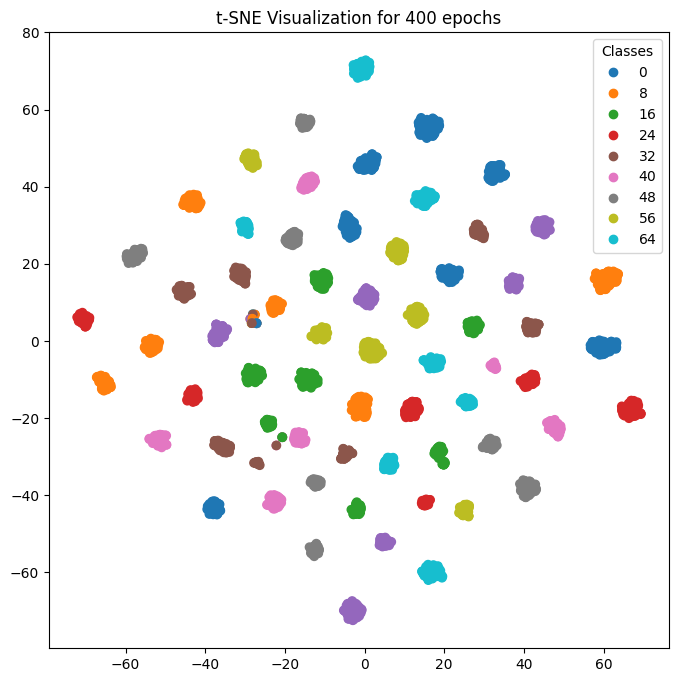

In [57]:
# Modify the model to output features from the second-last layer
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Everything except the last fully connected layer
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the output from (batch_size, 2048, 1, 1) to (batch_size, 2048)
        return x

feature_extractor = FeatureExtractor(model)
feature_extractor.eval()

# Prepare your dataset and DataLoader
# Assuming you have a dataloader (test_loader) prepared for your dataset
features_list = []
labels_list = []

with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        features = feature_extractor(data)
        features_list.append(features.cpu())  # Collect features
        labels_list.append(labels.cpu())      # Collect labels

# Stack all features and labels into a single tensor
features = torch.cat(features_list, dim=0)
labels = torch.cat(labels_list, dim=0)

# Convert features to NumPy for t-SNE
features_np = features.numpy()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_np)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels.numpy(), cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization for 400 epochs")
plt.show()


/tmp/ipykernel_277152/1487247915.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./hw1_data/model/p1_c_1ep.pt'))


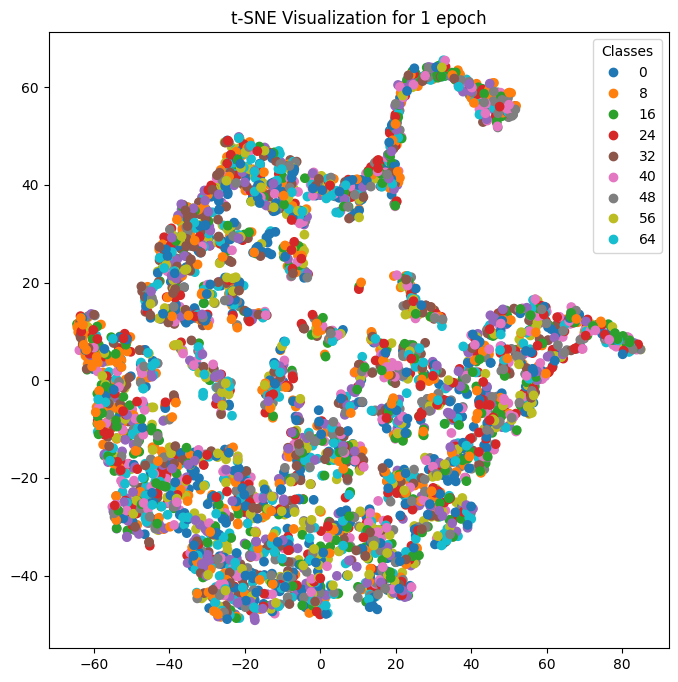

In [58]:
model.load_state_dict(torch.load('./hw1_data/model/p1_c_1ep.pt'))

feature_extractor = FeatureExtractor(model)
feature_extractor.eval()

# Prepare your dataset and DataLoader
# Assuming you have a dataloader (test_loader) prepared for your dataset
features_list = []
labels_list = []

with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        features = feature_extractor(data)
        features_list.append(features.cpu())  # Collect features
        labels_list.append(labels.cpu())      # Collect labels

# Stack all features and labels into a single tensor
features = torch.cat(features_list, dim=0)
labels = torch.cat(labels_list, dim=0)

# Convert features to NumPy for t-SNE
features_np = features.numpy()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_np)

# Plot the t-SNE results
plt.figure(figsize=(8, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels.numpy(), cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization for 1 epoch")
plt.show()
